<h4 style="text-align: center; color: #BD6C37;"> <i> Ecole Polytechnique de Thiès <br>  Département Génie Informatique et Télécommunications </i> </h4>
<h1 style="text-align: center"> Principes MLOps </h1>
<h5 style="text-align: center">DIC3-GIT, 2023-2024</h5>
<h5 style="text-align: center">Mme Mously DIAW</h5>
<h1 style="text-align: center; color:#90edaa">Projet matière : Natural Language Processing with Disaster Tweets</h1>
<h5 style="text-align: center"> Par Kikia DIA, Mouhamadou Naby DIA, Ndeye Awa SALANE </h5>
<h3 style="text-align: center; color:#9000aa; text-decoration:underline"> I. Exploratory Data Analysis (EDA) </h3>


<a id="0"></a> <br>
### Sommaire
#### [Introduction](#1)
1. [Compréhension des données](#2)
1. [Exploration des données brutes](#3)
1. [Cleaning des données](#4)
1. [Exploration des données nettoyées](#8)
#### [Conclusion](#5)
* <i>[References](#6)</i>
* <i>[Authors](#7)</i>

<a id="1"></a> 
#### Introduction [⏮️]()[👆🏽](#0)[⏭️](#2)

<div style="display: flex;">
     <div style="flex: 1;">
         <img src="https://storage.googleapis.com/kaggle-media/competitions/tweet_screenshot.png" alt="Descriptive Image" style="width: 100%; height:90%;">
     </div>
     <div style="flex: 
         4; padding-y: 10px; padding-left: 10px; text-align: justify">
         <p>
             🌀 Twitter est devenu un important canal de communication en cas d’urgence.
             <br><br>
             🌀 L’omniprésence des smartphones permet aux gens d’annoncer une urgence qu’ils observent en temps réel. Pour cette raison, de plus en plus d’organismes s’intéressent à la surveillance programmatique de Twitter (c.-à-d. les organisations de secours aux sinistrés et les agences de presse).
             <br><br>
             🌀 Mais on ne sait pas toujours si les paroles d’une personne annoncent réellement un désastre (comme en témoigne l'image ci-contre).
             <br><br>
             🌀 L’auteur utilise explicitement le mot « ABLAZE » (qui veut dire "En Feu") mais le dit métaphoriquement, ce qui est clair pour un homme dès le départ, surtout avec l’aide visuelle. Mais c’est moins clair pour une machine.
             <br><br>
             🌀 C’est pourquoi nous avons choisis d’utiliser un modèle de langage qui prédit quels Tweets sont sur des catastrophes réelles et lesquels ne le sont pas. Nous allons utiliser à un ensemble de données de 10000 tweets qui ont été classifiés. 
         </p>
     </div>
</div>


#### Import des librairies

In [1]:
# Ajouter le répertoire parent pour les imports de module
import sys
sys.path.append('..')

import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

from src.logging.main import LoggerManager
from src.visualization.main import (
  plot_disaster_and_non_disaster_bar_distribution,
  plot_disaster_and_non_disaster_pie_distribution,
  plot_tweet_length_histogram,
  plot_tweet_word_length_histogram,
  plot_average_word_length_for_each_tweet_histogram,
  plot_most_common_stopwords,
  plot_most_common_words,
  plot_most_common_bigrams,
  plot_most_common_trigrams,
  plot_most_common_keywords,
  plot_most_common_locations,
  plot_wordcloud
)

from src.data.make_dataset import get_dataset
from src.utilities.main import (
  remove_emoji,
  remove_html,
  remove_punctuation,
  remove_URL,
  correct_spellings,
  remove_stopwords,
  remove_accents,
  remove_ampersand,
  remove_non_necessary_spaces,
  remove_weird_content,
  remove_numerical_values,
  replace_percent20_with_space,
  expand_contractions,
  lemmatize_text,
  clean
)

from src.models.main import (
  read_and_split_data,
  train_pretrained_model, plot_confusion_matrix, plot_training_history
)

from src.data.params import MODEL_PARAMS, SEED

from src.profiling.main import (
  make_profile_report
)

%matplotlib inline


log = LoggerManager('disaster_tweets_logging.ipynb')

[nltk_data] Error loading stopwords: <urlopen error [Errno 8] nodename
[nltk_data]     nor servname provided, or not known>
[nltk_data] Error loading punkt: <urlopen error [Errno 8] nodename nor
[nltk_data]     servname provided, or not known>
/opt/homebrew/Caskroom/miniforge/base/envs/tf-gpu/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<a id="2"></a> 
#### 1. Compréhension des données [⏮️](#1)[👆🏽](#0)[⏭️](#3)

In [2]:
train, test = get_dataset(raw=True)

🔆 Affichage des trois premières lignes du dataframe pour le train et le test set

🔆 Nous avons 5 colonnes dans le train set
- 🦜 `id`: identifiant du tweet
- 🦜 `keyword`: mot-clé associé au tweet
- 🦜 `location`: la localisation depuis lequel le tweet a été publié
- 🦜 `text`: contenu du tweet
- 🦜 `target`: 0 ou 1 si le tweet est un tweet de catastrophe

In [3]:
train.head(6)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1


🔆 Nous avons 4 colonnes dans le test set
- 🦜 `id`: identifiant du tweet
- 🦜 `keyword`: mot-clé associé au tweet
- 🦜 `location`: la localisation depuis lequel le tweet a été publié
- 🦜 `text`: contenu du tweet
- 🦜 `target`: 0 ou 1 si le tweet est un tweet de catastrophe

In [4]:
test.head(6)

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
5,12,NaN,NaN,We're shaking...It's an earthquake


🔆 Nous avons `7613 entrées` dans le train set
  - 🦜 `id`: est de type int
  - 🦜 `keyword`: est de type object (string). Peut-être null (7552 non null sur 7613 soit près `99.19% de valeurs non null`)
  - 🦜 `location`: est de type object (string). Peut-être null (5080 non null sur 7613 soit `66.72% de valeurs non null`)
  - 🦜 `text`: est de type object (string)
  - 🦜 `target`: est de type int (0 ou 1)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


🔆 Nous avons `3263 entrées` dans le test set
  - 🦜 `id`: est de type int
  - 🦜 `keyword`: est de type object (string)
  - 🦜 `location`: est de type object (string et peut-être null; 2158 non null sur 3263 soit `66.13% de valeurs non null`)
  - 🦜 `text`: est de type object (string)
  - 🦜 `target`: est de type int (0 ou 1)

In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


🔆 Cela nous fait au total 10876 tweets au total

<a id="3"></a> 
#### 2. Exploration des données brutes [⏮️](#2)[👆🏽](#0)[⏭️](#4)

#### Profiling

In [7]:
make_profile_report(raw=True)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

##### Distribution des Tweets

In [8]:
plot_disaster_and_non_disaster_bar_distribution(raw=True)

In [9]:
plot_disaster_and_non_disaster_pie_distribution(raw=True)

🔆 Il y'a plus de tweets non désastreuses que de tweets désastreuses

🔆 Non désastres: `class 0 au total 4342 soit 57%`

🔆 Désastres: `class 1 au total 3271 soit 43%`

In [10]:
plot_tweet_length_histogram(raw=True)

🔆 La distribution des tweets est très similaire. 120 à 140 caractères sont les plus communs.

##### Longueur des mots dans les tweets 

In [11]:
plot_tweet_word_length_histogram(raw=True)

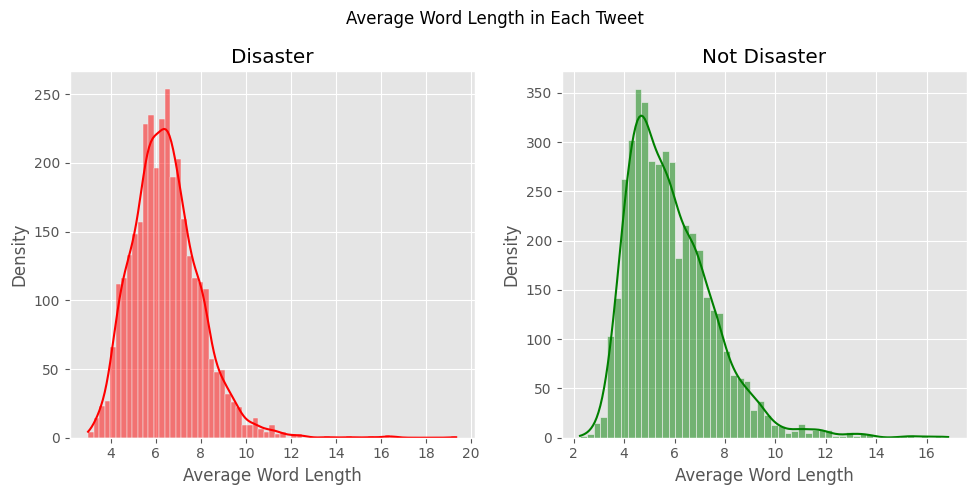

In [12]:
plot_average_word_length_for_each_tweet_histogram(raw=True)

##### Stopwords les plus communs dans les tweets

In [13]:
plot_most_common_stopwords(raw=True, top=15)

🔆 Dans les deux cas, le stopword `"the"` domine.

🔆 Dans les tweets de non désastres (class 0), il est suivi par le stopword `"a"`.

🔆 Dans les tweets de désastres (class 1), il est suivi du stopword `"in"`.

🔆 Les punctuations dans les tweets

In [14]:
plot_most_common_stopwords(raw=True, top=15)

🔆 Les mots les plus communs 

In [15]:
plot_most_common_words(raw=True, top=100)

##### Ngrams

In [16]:
plot_most_common_bigrams(raw=True, top=15)

In [17]:
plot_most_common_trigrams(raw=True, top=15)

In [18]:
plot_most_common_keywords(raw=True, top=15)

##### Distribution des tweets par lieu

In [19]:
plot_most_common_locations(raw=True, top=15)

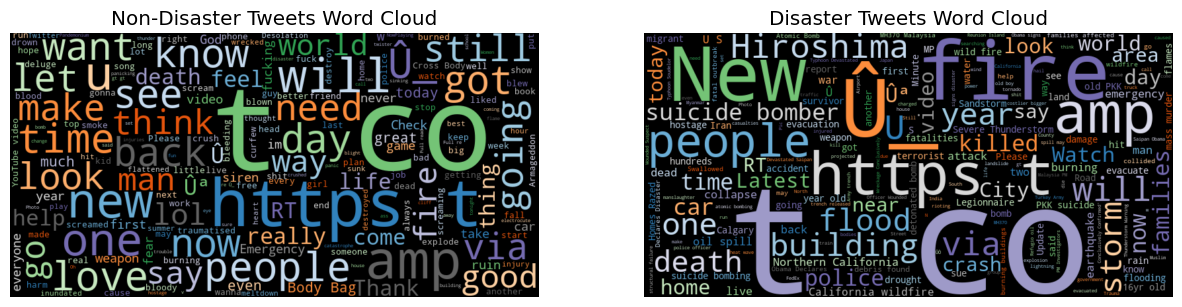

In [20]:
plot_wordcloud(raw=True)

<a id="4"></a> 
#### 3. Cleaning des données [⏮️](#3)[👆🏽](#0)[⏭️](#5)

♻️ Remove URLs

In [21]:
example="New competition launched: https://www.kaggle.com/c/nlp-getting-started"

log.debug(remove_URL(example))

2024-08-04 17:46:45 [debug    ] New competition launched:      filename=disaster_tweets_logging.ipynb hostname=192.168.1.97 ip_address=192.168.1.97


♻️ Remove HTML

In [22]:
example = """<div>
<h1>Real or Fake</h1>
<p>Kaggle </p>
<a href="https://www.kaggle.com/c/nlp-getting-started">getting started</a>
</div>"""

log.debug(remove_html(example))

2024-08-04 17:46:45 [debug    ] 
Real or Fake
Kaggle 
getting started
 filename=disaster_tweets_logging.ipynb hostname=192.168.1.97 ip_address=192.168.1.97


♻️ Remove Emoji

In [23]:
log.debug(remove_emoji("Omg another Earthquake 😔😔"))

2024-08-04 17:46:45 [debug    ] Omg another Earthquake         filename=disaster_tweets_logging.ipynb hostname=192.168.1.97 ip_address=192.168.1.97


♻️ Removing punctuations

In [24]:
example="I am a #king"
log.debug(remove_punctuation(example))

2024-08-04 17:46:45 [debug    ] I am a king                    filename=disaster_tweets_logging.ipynb hostname=192.168.1.97 ip_address=192.168.1.97


♻️ Correct Spelling

In [25]:
%%time

text = "corect me plese"
log.debug(correct_spellings(text))

2024-08-04 17:46:45 [debug    ] correct me please              filename=disaster_tweets_logging.ipynb hostname=192.168.1.97 ip_address=192.168.1.97
CPU times: user 5.48 ms, sys: 1.28 ms, total: 6.75 ms
Wall time: 2.04 ms


In [26]:
%%time


train['text']= train['text'].apply(lambda x : clean(x))
train['text']= train['text'].apply(lambda x : remove_URL(x))
train['text']= train['text'].apply(lambda x : remove_html(x))
train['text']= train['text'].apply(lambda x: remove_emoji(x))
train['text']= train['text'].apply(lambda x : remove_punctuation(x))
train['text']= train['text'].apply(lambda x : expand_contractions(x))
train['text']= train['text'].apply(lambda x : remove_stopwords(x))
train['text']= train['text'].apply(lambda x : remove_ampersand(x))
train['text']= train['text'].apply(lambda x : remove_weird_content(x))
train['text']= train['text'].apply(lambda x : remove_numerical_values(x))
train['text']= train['text'].apply(lambda x : remove_accents(x))
train['text']= train['text'].apply(lambda x : remove_non_necessary_spaces(x))
train['text']= train['text'].apply(lambda x : replace_percent20_with_space(x))
train['text']= train['text'].apply(lambda x : lemmatize_text(x))


train['keyword']= train['keyword'].apply(lambda x : replace_percent20_with_space(x))
train['keyword']= train['keyword'].apply(lambda x : lemmatize_text(x))

train['location']= train['location'].apply(lambda x : remove_punctuation(x))
train['location']= train['location'].apply(lambda x : remove_stopwords(x))
train['location']= train['location'].apply(lambda x : remove_weird_content(x))
train['location']= train['location'].apply(lambda x : remove_numerical_values(x))
train['location']= train['location'].apply(lambda x : remove_non_necessary_spaces(x))

train.to_csv('../data/processed/train.csv', index=False)

CPU times: user 1min 47s, sys: 298 ms, total: 1min 47s
Wall time: 1min 48s


In [27]:
%%time


test['text']= test['text'].apply(lambda x : clean(x))
test['text']= test['text'].apply(lambda x : remove_URL(x))
test['text']= test['text'].apply(lambda x : remove_html(x))
test['text']= test['text'].apply(lambda x: remove_emoji(x))
test['text']= test['text'].apply(lambda x : remove_punctuation(x))
test['text']= test['text'].apply(lambda x : expand_contractions(x))
test['text']= test['text'].apply(lambda x : remove_stopwords(x))
test['text']= test['text'].apply(lambda x : remove_ampersand(x))
test['text']= test['text'].apply(lambda x : remove_weird_content(x))
test['text']= test['text'].apply(lambda x : remove_numerical_values(x))
test['text']= test['text'].apply(lambda x : remove_accents(x))
test['text']= test['text'].apply(lambda x : remove_non_necessary_spaces(x))
test['text']= test['text'].apply(lambda x : replace_percent20_with_space(x))
test['text']= test['text'].apply(lambda x : lemmatize_text(x))


test['keyword']= test['keyword'].apply(lambda x : replace_percent20_with_space(x))
test['keyword']= test['keyword'].apply(lambda x : lemmatize_text(x))

test['location']= test['location'].apply(lambda x : remove_punctuation(x))
test['location']= test['location'].apply(lambda x : remove_stopwords(x))
test['location']= test['location'].apply(lambda x : remove_weird_content(x))
test['location']= test['location'].apply(lambda x : remove_numerical_values(x))
test['location']= test['location'].apply(lambda x : remove_non_necessary_spaces(x))

test.to_csv('../data/processed/test.csv', index=False)

CPU times: user 45.3 s, sys: 106 ms, total: 45.4 s
Wall time: 45.7 s


<a id="8"></a> 
#### 4. Exploration des données nettoyées [⏮️](#3)[👆🏽](#0)[⏭️](#5)

#### Profiling

In [28]:
make_profile_report(raw=False)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

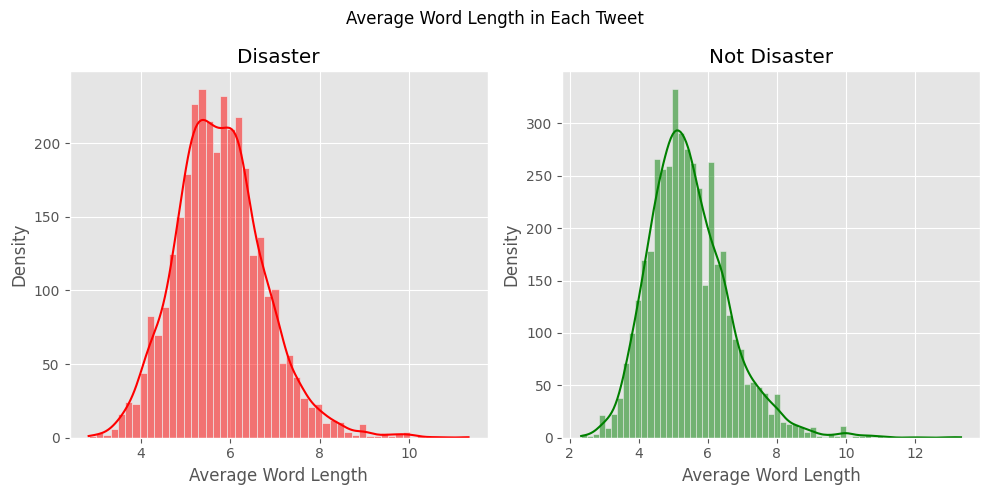

In [29]:
plot_average_word_length_for_each_tweet_histogram(raw=False)

In [30]:
plot_tweet_length_histogram(raw=False)

In [31]:
plot_tweet_word_length_histogram(raw=False)

In [32]:
plot_most_common_keywords(raw=False)

In [33]:
plot_most_common_locations(raw=False)

In [34]:
plot_most_common_words(raw=False, top=100)

In [35]:
plot_most_common_bigrams(raw=False, top=15)

In [36]:
plot_most_common_trigrams(raw=False, top=15)

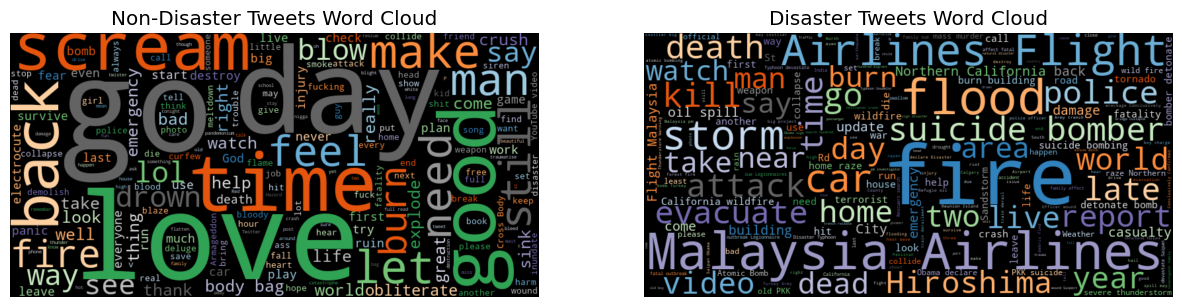

In [37]:
plot_wordcloud(raw=False)

In [2]:
import tensorflow as tf
log.debug(f"Num GPUs Available: {len(tf.config.list_physical_devices('GPU'))}")

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import dagshub
import mlflow
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Initialize DagsHub and MLflow
dagshub.init(repo_owner='dnaby', repo_name='NLP-Disaster-Tweets-Detection', mlflow=True)

#experiment_id = mlflow.create_experiment("Disaster-Tweets-Detection")
experiment_id = 2


2024-08-07 18:56:54 [debug    ] Num GPUs Available: 1          filename=disaster_tweets_logging.ipynb hostname=Mouhamadou-Naby-DIA.local ip_address=127.0.0.1


Accessing as dnaby

Initialized MLflow to track repo "dnaby/NLP-Disaster-Tweets-Detection"

Repository dnaby/NLP-Disaster-Tweets-Detection initialized!

In [ ]:

# Implement EarlyStopping and ModelCheckpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint(filepath='../model_checkpoint/roberta-base-{epoch:02d}-{val_loss:.2f}.h5', 
                             monitor='val_loss', save_best_only=True, save_weights_only=True)

x_train, y_train, x_val, y_val, x_test = read_and_split_data()

model, train_encodings, val_encodings, class_weights = train_pretrained_model(model_name='roberta-base', lr=1e-5)

# Customize the run name and tags
CURRENT_DATE = datetime.now()


with mlflow.start_run(run_name=f"disaster_tweets_{CURRENT_DATE.strftime('%Y_%m_%d_%H_%M_%S')}",
                      experiment_id=experiment_id,
                      tags={"version": "v1", "priority": "P1", "Dataset": "Disaster Tweets"},
                      description="Disaster tweets classification modeling") as mlf_run:
    # Log model parameters
    mlflow.log_params({
        'model_name': 'roberta-base',
        'learning_rate': 1e-5,
        'epochs': 50,
        'batch_size': 32  # Assuming batch size, adjust if different
    })

    # Train the model
    history = model.fit(
        {
          'input_ids': train_encodings['input_ids'], 
          'attention_mask': train_encodings['attention_mask']}, 
        y_train, 
        epochs=50, 
        validation_data=(
            {
              'input_ids': val_encodings['input_ids'], 
              'attention_mask': val_encodings['attention_mask']}, 
            y_val
        ), 
        verbose=1,
        class_weight=class_weights,  # Use class weights
        callbacks=[early_stopping, checkpoint]  # Add EarlyStopping and ModelCheckpoint
    )

    # Evaluate the model on validation set
    loss, accuracy = model.evaluate(val_encodings, y_val)
    log.debug(f"Validation accuracy: {accuracy:.4f}")

    # Log metrics to MLflow
    mlflow.log_metric('val_loss', loss)
    mlflow.log_metric('val_accuracy', accuracy)

    # Log training history
    for metric_name, metric_values in history.history.items():
        for epoch, value in enumerate(metric_values):
            mlflow.log_metric(metric_name, value, step=epoch)

    # Make predictions on validation set
    y_pred = model.predict(val_encodings).logits.argmax(-1)

    # Print classification report
    class_report = classification_report(y_val, y_pred, output_dict=True)
    log.debug("\n" + classification_report(y_val, y_pred))

    # Log classification report
    mlflow.log_dict(class_report, 'classification_report.json')

    # Create confusion matrix
    conf_matrix = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.savefig(f'../reports/mlflow/confusion_matrix.png')
    mlflow.log_artifact('../reports/mlflow/confusion_matrix.png')

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(f'../reports/mlflow/training_history.png')
    mlflow.log_artifact('../reports/mlflow/training_history.png')

    # Log the model with a custom name
    mlflow.tensorflow.log_model(model, artifact_path='model', registered_model_name='DisasterTweetsModel')

In [ ]:

# Implement EarlyStopping and ModelCheckpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint(filepath='../model_checkpoint/roberta-base-{epoch:02d}-{val_loss:.2f}.h5', 
                             monitor='val_loss', save_best_only=True, save_weights_only=True)

x_train, y_train, x_val, y_val, x_test = read_and_split_data()

model, train_encodings, val_encodings, class_weights = train_pretrained_model(model_name='roberta-base', lr=1e-5)

# Customize the run name and tags
CURRENT_DATE = datetime.now()


with mlflow.start_run(run_name=f"disaster_tweets_{CURRENT_DATE.strftime('%Y_%m_%d_%H_%M_%S')}",
                      experiment_id=experiment_id,
                      tags={"version": "v1", "priority": "P1", "Dataset": "Disaster Tweets"},
                      description="Disaster tweets classification modeling") as mlf_run:
    # Log model parameters
    mlflow.log_params({
        'model_name': 'roberta-base',
        'learning_rate': 1e-5,
        'epochs': 50,
        'batch_size': 32  # Assuming batch size, adjust if different
    })

    # Train the model
    history = model.fit(
        {
          'input_ids': train_encodings['input_ids'], 
          'attention_mask': train_encodings['attention_mask']}, 
        y_train, 
        epochs=50, 
        validation_data=(
            {
              'input_ids': val_encodings['input_ids'], 
              'attention_mask': val_encodings['attention_mask']}, 
            y_val
        ), 
        verbose=1,
        class_weight=class_weights,  # Use class weights
        callbacks=[early_stopping, checkpoint]  # Add EarlyStopping and ModelCheckpoint
    )

    # Evaluate the model on validation set
    loss, accuracy = model.evaluate(val_encodings, y_val)
    log.debug(f"Validation accuracy: {accuracy:.4f}")

    # Log metrics to MLflow
    mlflow.log_metric('val_loss', loss)
    mlflow.log_metric('val_accuracy', accuracy)

    # Log training history
    for metric_name, metric_values in history.history.items():
        for epoch, value in enumerate(metric_values):
            mlflow.log_metric(metric_name, value, step=epoch)

    # Make predictions on validation set
    y_pred = model.predict(val_encodings).logits.argmax(-1)

    # Print classification report
    class_report = classification_report(y_val, y_pred, output_dict=True)
    log.debug("\n" + classification_report(y_val, y_pred))

    # Log classification report
    mlflow.log_dict(class_report, 'classification_report.json')

    # Create confusion matrix
    conf_matrix = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.savefig(f'../reports/mlflow/confusion_matrix.png')
    mlflow.log_artifact('../reports/mlflow/confusion_matrix.png')

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(f'../reports/mlflow/training_history.png')
    mlflow.log_artifact('../reports/mlflow/training_history.png')

    # Log the model with a custom name
    mlflow.tensorflow.log_model(model, artifact_path='model', registered_model_name='DisasterTweetsModel')

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
  Dense, LSTM, Embedding, Dropout, Bidirectional, SimpleRNN, GRU
)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.legacy import Adam, RMSprop
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

x_train, y_train, x_val, y_val, x_test = read_and_split_data()

# Assuming the text column is the one that needs to be processed for LSTM
# Tokenization and padding for the text data
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(x_train)

x_train = tokenizer.texts_to_sequences(x_train)
x_train = pad_sequences(x_train, maxlen=10)

x_val = tokenizer.texts_to_sequences(x_val)
x_val = pad_sequences(x_val, maxlen=10)

# Building the LSTM model
def create_model(ann_units=64, dropout_rate=0.5, embedding_dim=20, relu_units=64, embedding_input_dim=2000, optimizer='adam', loss='binary_crossentropy', relu=False):
  model = Sequential(name="Model")
  model.add(Embedding(embedding_input_dim, embedding_dim, name='embedding'))
  model.add((SimpleRNN(ann_units, name='RNN')))
  if relu:
    model.add(Dense(relu_units, activation='relu', name='relu'))
    model.add(Dropout(dropout_rate, name='dropout'))
  model.add(Dense(1, activation='sigmoid', name='sigmoid'))
  model.build(input_shape=(None, embedding_dim))
  model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
  return model

# Implement EarlyStopping and ModelCheckpoint
early_stopping = EarlyStopping(
  monitor='val_loss', 
  patience=3, 
  restore_best_weights=True
)
checkpoint = ModelCheckpoint(
  filepath='../model_checkpoint/RNN-{epoch:02d}-{val_loss:.2f}.h5', 
  monitor='val_loss', save_best_only=True, save_weights_only=True
)

model = create_model(optimizer=RMSprop(learning_rate=1e-4), relu=True, ann_units=32, embedding_dim=10)
log.debug(model.summary())

# Customize the run name and tags
CURRENT_DATE = datetime.now()

with mlflow.start_run(run_name=f"disaster_tweets_{CURRENT_DATE.strftime('%Y_%m_%d_%H_%M_%S')}",
                      experiment_id=experiment_id,
                      tags={"version": "v1", "priority": "P1", "Dataset": "Disaster Tweets"},
                      description="Disaster tweets classification modeling") as mlf_run:
  # Log model parameters
  mlflow.log_params({
      'model_name': 'RNN',
      'learning_rate': 1e-4,
      'ann_units': 32,
      'dropout_rate': 0.5,
      'embedding_dim': 10,
      'relu_units': 64,
      'optimizer': 'adam',
      'loss': 'binary_crossentropy',
      'epochs': 20,
      'batch_size': 32  # Assuming batch size, adjust if different
  })

  # Train the model
  history = model.fit(
      x_train, 
      y_train, 
      epochs=20, 
      validation_data=(x_val, y_val), 
      verbose=1,
      callbacks=[early_stopping, checkpoint]  # Add EarlyStopping
  )

  # Evaluate the model on validation set
  loss, accuracy = model.evaluate(x_val, y_val)
  log.debug(f"Validation accuracy: {accuracy:.4f}")

  # Log metrics to MLflow
  mlflow.log_metric('val_loss', loss)
  mlflow.log_metric('val_accuracy', accuracy)

  # Log training history
  for metric_name, metric_values in history.history.items():
      for epoch, value in enumerate(metric_values):
          mlflow.log_metric(metric_name, value, step=epoch)

  # Make predictions on validation set
  y_pred = (model.predict(x_val) > 0.5).astype("int32")

  # Print classification report
  class_report = classification_report(y_val, y_pred, output_dict=True)
  log.debug("\n" + classification_report(y_val, y_pred))

  # Log classification report
  mlflow.log_dict(class_report, 'classification_report.json')

  # Create confusion matrix
  conf_matrix = confusion_matrix(y_val, y_pred)
  plt.figure(figsize=(8, 6))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
  plt.title('Confusion Matrix')
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.savefig(f'../reports/mlflow/confusion_matrix.png')
  mlflow.log_artifact('../reports/mlflow/confusion_matrix.png')

  # Plot training history
  plt.figure(figsize=(12, 4))
  plt.subplot(1, 2, 1)
  plt.plot(history.history['accuracy'], label='Train Accuracy')
  plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
  plt.title('Model Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'], label='Train Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.title('Model Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.savefig(f'../reports/mlflow/training_history.png')
  mlflow.log_artifact('../reports/mlflow/training_history.png')

  # Log the model with a custom name
  mlflow.tensorflow.log_model(model, artifact_path='model', registered_model_name='DisasterTweetsRNN')


Model: "Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 20)          40000     
                                                                 
 RNN (SimpleRNN)             (None, 64)                5440      
                                                                 
 relu (Dense)                (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 sigmoid (Dense)             (None, 1)                 65        
                                                                 
Total params: 49665 (194.00 KB)
Trainable params: 49665 (194.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
2024-08-07 19:47:52 [de

2024-08-05 23:48:35 [debug    ] 
X train: (6090, 3)
Y train: (6090,)
X test: (1523, 3)
Y test: (1523,) filename=disaster_tweets_logging.ipynb hostname=192.168.1.23 ip_address=192.168.1.23


Model: "Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 20, 20)         │        40,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BiLSTM (Bidirectional)          │ (None, 32)             │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu1 (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sigmoid (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,913 (183.25 KB)

 Trainable params: 46,913 (183.25 KB)

 Non-trainable params: 0 (0.00 B)

2024-08-05 23:48:35 [debug    ] filename=disaster_tweets_logging.ipynb hostname=192.168.1.23 ip_address=192.168.1.23
Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.5836 - loss: 0.6714 - val_accuracy: 0.7899 - val_loss: 0.5027
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7928 - loss: 0.4668 - val_accuracy: 0.8050 - val_loss: 0.4417
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.8330 - loss: 0.3916 - val_accuracy: 0.8050 - val_loss: 0.4463
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8470 - loss: 0.3659 - val_accuracy: 0.8089 - val_loss: 0.4404
Epoch 5/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.8482 - loss: 0.3651 - val_accuracy: 0.8089 - val_loss: 0.4463
Epoch 6/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.8578 - loss: 0.3566 - val_accuracy: 0.8056 - val_loss: 0.4491
Epoch 7/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.8607 - loss: 0.3469 - val_accuracy: 0.8070

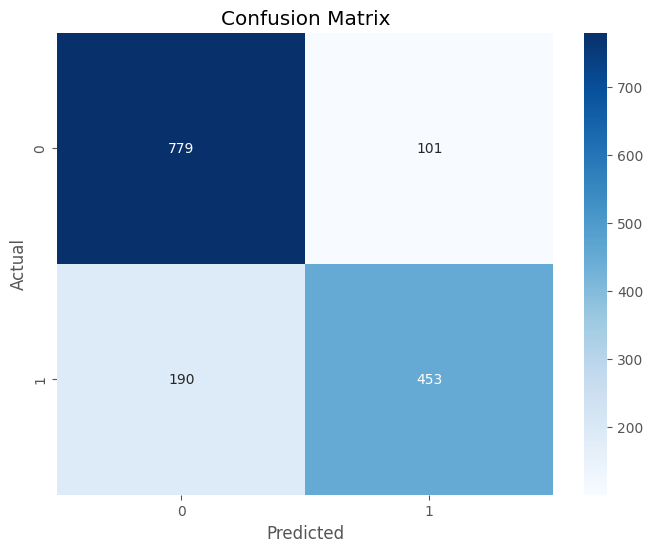

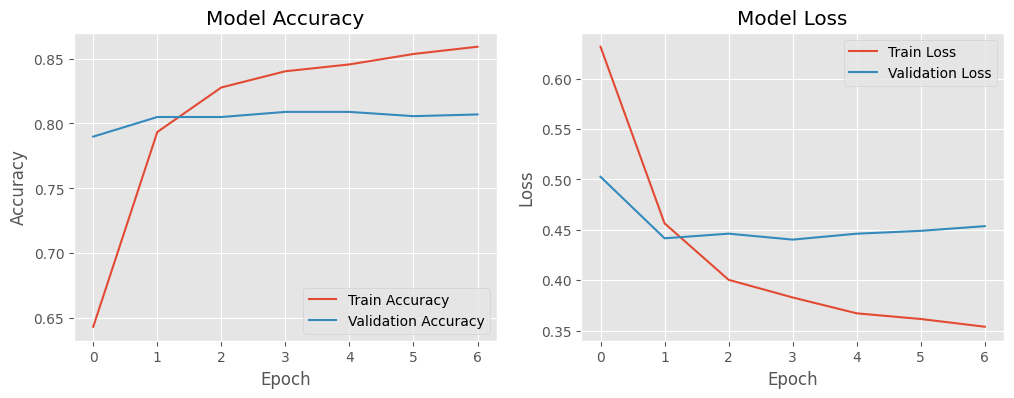

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
  Dense, LSTM, Embedding, Dropout, Bidirectional, GRU,
)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

train, test = get_dataset(raw=False)

FEATURES = MODEL_PARAMS["DEFAULT_FEATURE_NAMES"]
TARGET_NAME = MODEL_PARAMS["TARGET_NAME"]

x_train, x_val, y_train, y_val = train_test_split(
  train.loc[:, FEATURES],
  train[TARGET_NAME],
  test_size=MODEL_PARAMS["TEST_SIZE"],
  random_state=SEED
)

log.debug(f"\nX train: {x_train.shape}\nY train: {y_train.shape}\n"
            f"X test: {x_val.shape}\nY test: {y_val.shape}")

train['keyword'] = train['keyword'].fillna('')
x_train['keyword'] = x_train['keyword'].fillna('')
x_val['keyword'] = x_val['keyword'].fillna('')

# Assuming the text column is the one that needs to be processed for LSTM
# Tokenization and padding for the text data
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(train['keyword'] + ' ' + train['text'])

x_train = tokenizer.texts_to_sequences(x_train['keyword'] + ' ' + x_train['text'])
x_train = pad_sequences(x_train, maxlen=100)

x_val = tokenizer.texts_to_sequences(x_val['keyword'] + ' ' + x_val['text'])
x_val = pad_sequences(x_val, maxlen=100)

y_train = y_train.values
y_val = y_val.values

# Building the LSTM model
def create_model(lstm_units=16, dropout_rate=0.5, embedding_dim=20, relu_units=64, embedding_input_dim=2000, optimizer='rmsprop', loss='binary_crossentropy'):
  model = Sequential(name="Model")
  model.add(Embedding(embedding_input_dim, embedding_dim, name='embedding'))
  model.add(Bidirectional(LSTM(lstm_units), name='BiLSTM'))
  model.add(Dense(relu_units, activation='relu', name='relu1'))
  model.add(Dropout(dropout_rate, name='dropout'))
  model.add(Dense(1, activation='sigmoid', name='sigmoid'))
  model.build(input_shape=(None, embedding_dim))
  model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
  return model

model = create_model()
log.debug(model.summary())

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val), callbacks=[early_stopping], verbose=1)

# Evaluate the model on validation set
loss, accuracy = model.evaluate(x_val, y_val)
log.debug(f"Validation accuracy: {accuracy:.4f}")

# Make predictions on validation set
y_pred = (model.predict(x_val) > 0.5).astype(int)

# Print classification report
log.debug("\n" + classification_report(y_val, y_pred))

# Create confusion matrix
confusion_matrix = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

2024-08-05 23:52:00 [debug    ] 
X train: (6090, 3)
Y train: (6090,)
X test: (1523, 3)
Y test: (1523,) filename=disaster_tweets_logging.ipynb hostname=192.168.1.23 ip_address=192.168.1.23


Model: "Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 15, 15)         │        30,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BiLSTM (GRU)                    │ (None, 32)             │         4,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sigmoid (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,737 (135.69 KB)

 Trainable params: 34,737 (135.69 KB)

 Non-trainable params: 0 (0.00 B)

2024-08-05 23:52:00 [debug    ] filename=disaster_tweets_logging.ipynb hostname=192.168.1.23 ip_address=192.168.1.23
Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.6018 - loss: 0.6670 - val_accuracy: 0.7544 - val_loss: 0.5311
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8011 - loss: 0.4671 - val_accuracy: 0.8076 - val_loss: 0.4373
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8326 - loss: 0.3935 - val_accuracy: 0.7984 - val_loss: 0.4464
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8420 - loss: 0.3782 - val_accuracy: 0.8070 - val_loss: 0.4396
Epoch 5/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8475 - loss: 0.3655 - val_accuracy: 0.8037 - val_loss: 0.4484
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8100 - loss: 0.4313
2024-08-05 23:52:18 [debug    ] Validation accuracy: 0.8076    filename=disaster_tweets_logging.ipynb hostname=192.168.1.23 ip_address=192.168.1.23
48/48 ━━━━━━━━━━━

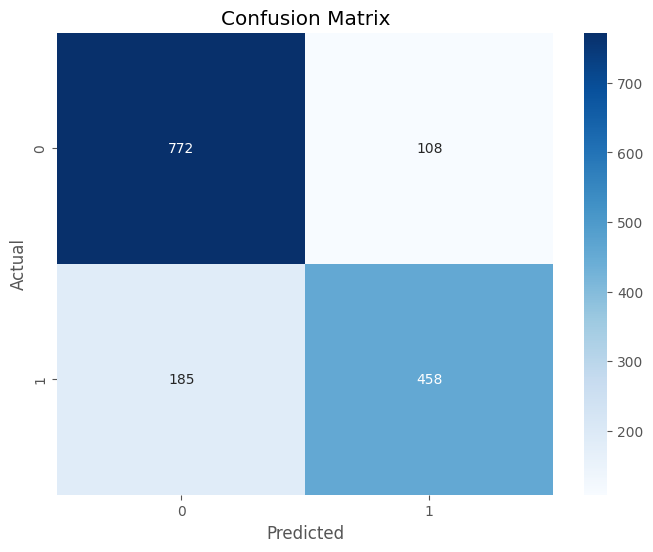

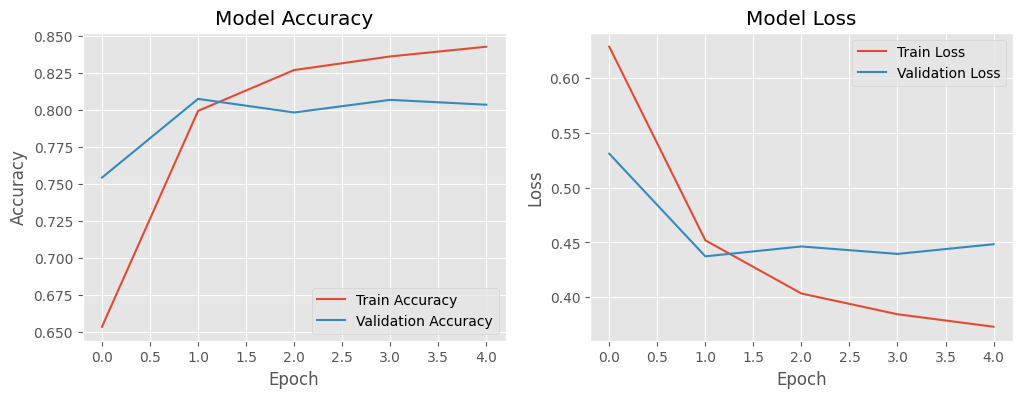

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
  Dense, LSTM, Embedding, Dropout, Bidirectional, GRU,
)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

train, test = get_dataset(raw=False)

FEATURES = MODEL_PARAMS["DEFAULT_FEATURE_NAMES"]
TARGET_NAME = MODEL_PARAMS["TARGET_NAME"]

x_train, x_val, y_train, y_val = train_test_split(
  train.loc[:, FEATURES],
  train[TARGET_NAME],
  test_size=MODEL_PARAMS["TEST_SIZE"],
  random_state=SEED
)

log.debug(f"\nX train: {x_train.shape}\nY train: {y_train.shape}\n"
            f"X test: {x_val.shape}\nY test: {y_val.shape}")

train['keyword'] = train['keyword'].fillna('')
x_train['keyword'] = x_train['keyword'].fillna('')
x_val['keyword'] = x_val['keyword'].fillna('')

# Assuming the text column is the one that needs to be processed for LSTM
# Tokenization and padding for the text data
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(train['keyword'] + ' ' + train['text'])

x_train = tokenizer.texts_to_sequences(x_train['keyword'] + ' ' + x_train['text'])
x_train = pad_sequences(x_train, maxlen=100)

x_val = tokenizer.texts_to_sequences(x_val['keyword'] + ' ' + x_val['text'])
x_val = pad_sequences(x_val, maxlen=100)

y_train = y_train.values
y_val = y_val.values

# Building the LSTM model
def create_model(lstm_units=32, dropout_rate=0.5, embedding_dim=15, relu_units=64, embedding_input_dim=2000, optimizer='rmsprop', loss='binary_crossentropy'):
  model = Sequential(name="Model")
  model.add(Embedding(embedding_input_dim, embedding_dim, name='embedding'))
  model.add(GRU(lstm_units, name='BiLSTM'))
  #model.add(Dense(relu_units, activation='relu', name='relu1'))
  model.add(Dropout(dropout_rate, name='dropout'))
  model.add(Dense(1, activation='sigmoid', name='sigmoid'))
  model.build(input_shape=(None, embedding_dim))
  model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
  return model

model = create_model()
log.debug(model.summary())

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val), callbacks=[early_stopping], verbose=1)

# Evaluate the model on validation set
loss, accuracy = model.evaluate(x_val, y_val)
log.debug(f"Validation accuracy: {accuracy:.4f}")

# Make predictions on validation set
y_pred = (model.predict(x_val) > 0.5).astype(int)

from sklearn.metrics import classification_report, confusion_matrix

# Print classification report
log.debug("\n" + classification_report(y_val, y_pred))

# Create confusion matrix
confusion_matrix = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

2024-08-07 08:03:52 [debug    ] Num GPUs Available: 1          filename=disaster_tweets_logging.ipynb hostname=192.168.1.32 ip_address=192.168.1.32
2024-08-07 08:03:52 [debug    ] 
X train: (6090, 3)
Y train: (6090,)
X test: (1523, 3)
Y test: (1523,) filename=disaster_tweets_logging.ipynb hostname=192.168.1.32 ip_address=192.168.1.32


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/50
191/191 [==============================] - 345s 2s/step - loss: 0.6857 - accuracy: 0.5847 - val_loss: 0.6652 - val_accuracy: 0.6684
Epoch 2/50
191/191 [==============================] - 141s 721ms/step - loss: 0.6470 - accuracy: 0.6826 - val_loss: 0.6201 - val_accuracy: 0.6986
Epoch 3/50
191/191 [==============================] - 141s 732ms/step - loss: 0.5904 - accuracy: 0.7397 - val_loss: 0.5758 - val_accuracy: 0.7288
Epoch 4/50
191/191 [==============================] - 126s 657ms/step - loss: 0.5394 - accuracy: 0.7594 - val_loss: 0.5291 - val_accuracy: 0.7708
Epoch 5/50
191/191 [==============================] - 112s 581ms/step - loss: 0.5084 - accuracy: 0.7796 - val_loss: 0.5040 - val_accuracy: 0.7787
Epoch 6/50
191/191 [==============================] - 106s 553ms/step - loss: 0.4818 - accuracy: 0.7961 - val_loss: 0.4902 - val_accuracy: 0.7814
Epoch 7/50
191/191 [==============================] - 107s 554ms/step - loss: 0.4662 - accuracy: 0.8020 - val_loss: 0.4766 - va

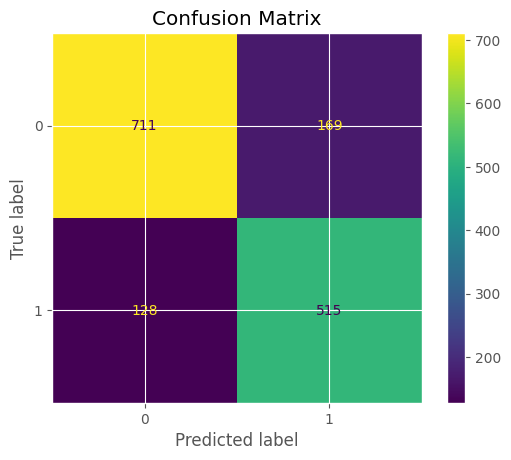

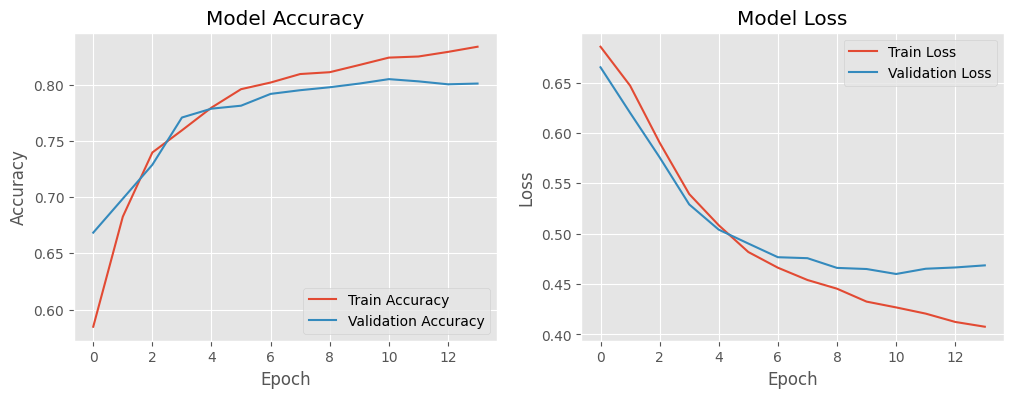

In [5]:
import tensorflow as tf
log.debug(f"Num GPUs Available: {len(tf.config.list_physical_devices('GPU'))}")
   
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.optimizers.legacy import Adam  # Changed to RMSProp optimizer
from tensorflow.keras.callbacks import EarlyStopping  # Import EarlyStopping
from tensorflow.keras.layers import Dropout
from tensorflow.keras import Model
from tensorflow.keras.regularizers import l2 

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


# Implement EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

train, test = get_dataset(raw=False)

FEATURES = MODEL_PARAMS["DEFAULT_FEATURE_NAMES"]
TARGET_NAME = MODEL_PARAMS["TARGET_NAME"]

x_train, x_val, y_train, y_val = train_test_split(
  train.loc[:, FEATURES],
  train[TARGET_NAME],
  test_size=MODEL_PARAMS["TEST_SIZE"],
  random_state=SEED
)

log.debug(f"\nX train: {x_train.shape}\nY train: {y_train.shape}\n"
            f"X test: {x_val.shape}\nY test: {y_val.shape}")

train['keyword'] = train['keyword'].fillna('')
x_train['keyword'] = x_train['keyword'].fillna('')
x_val['keyword'] = x_val['keyword'].fillna('')

# Concatenate 'text' and 'keyword' columns
x_train['concat_text'] = x_train['text'] + ' ' + x_train['keyword']
x_val['concat_text'] = x_val['text'] + ' ' + x_val['keyword']

# Load pre-trained model and tokenizer
model = TFAutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# Prepare data for training
train_encodings = tokenizer(x_train['concat_text'].tolist(), truncation=True, padding=True, return_tensors='tf')
val_encodings = tokenizer(x_val['concat_text'].tolist(), truncation=True, padding=True, return_tensors='tf')

# Convert labels to numpy arrays
train_labels = y_train.values
val_labels = y_val.values

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=train_labels)
class_weights = {0: class_weights[0], 1: class_weights[1]}

model.compile(optimizer=Adam(learning_rate=5e-7), loss=SparseCategoricalCrossentropy(from_logits=True), metrics=SparseCategoricalAccuracy('accuracy'))
# Train the model
history = model.fit(
    {
      'input_ids': train_encodings['input_ids'], 
      'attention_mask': train_encodings['attention_mask']}, 
    train_labels, 
    epochs=50, 
    validation_data=(
        {
          'input_ids': val_encodings['input_ids'], 
          'attention_mask': val_encodings['attention_mask']}, 
        val_labels
    ), 
    verbose=1,
    class_weight=class_weights,  # Use class weights
    callbacks=[early_stopping]  # Add EarlyStopping
)

# Evaluate the model on validation set
loss, accuracy = model.evaluate(val_encodings, val_labels)
log.debug(f"Validation accuracy: {accuracy:.4f}")

# Make predictions on validation set
y_pred = model.predict(val_encodings).logits.argmax(-1)

# Print classification report
log.debug("\n" + classification_report(val_labels, y_pred))

# Create confusion matrix
confusion_matrix = confusion_matrix(val_labels, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)
disp.plot()

plt.title('Confusion Matrix')
plt.show()

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [1]:
import dagshub
import mlflow
dagshub.init(repo_owner='dnaby', repo_name='NLP-Disaster-Tweets-Detection', mlflow=True)


with mlflow.start_run():
  # Your training code here...
  mlflow.log_metric('accuracy', 42)
  mlflow.log_param('Param name', 'Value')

Accessing as dnaby

Initialized MLflow to track repo "dnaby/NLP-Disaster-Tweets-Detection"

Repository dnaby/NLP-Disaster-Tweets-Detection initialized!

2024/08/07 09:34:21 INFO mlflow.tracking._tracking_service.client: 🏃 View run worried-calf-468 at: https://dagshub.com/dnaby/NLP-Disaster-Tweets-Detection.mlflow/#/experiments/0/runs/12fec743f91a4259b2a6b444404cf292.
2024/08/07 09:34:21 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/dnaby/NLP-Disaster-Tweets-Detection.mlflow/#/experiments/0.


<a id="5"></a> 
#### Conclusion [⏮️](#4)[👆🏽](#0)[⏭️](#6)

<a id="6"></a> 
#### <i>References</i> [⏮️](#5)[👆🏽](#0)[⏭️](#7)

Here is some text with a reference to the [Python documentation](https://docs.python.org/).

...

Here are some references for more information on the libraries used:

- [Pandas documentation](https://pandas.pydata.org/docs/)
- [NumPy documentation](https://numpy.org/doc/stable/)

🍀 Auteurs
- 🧑🏾‍💻 Kikia DIA
- 🧑🏾‍💻 Mouhamadou Naby DIA
- 🧑🏾‍💻 Ndeye Awa SALANE

🍀 Affiliations
- 🎓 Ecole Polytechnique de THIES

🍀 Département 
- 💻 Génie Informatique et Télécommunications

🍀 Niveau
- 📚 DIC3